In [34]:
!pip install nltk -q

In [41]:
import warnings 
warnings.filterwarnings("ignore")

In [125]:
import os
import sys
import torch
import torch.nn as nn 
import os

import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd
import numpy as np 

# torch 
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
from torch import optim 

# torchtexts
# from torchtext.data.utils import get_tokenizer
# from torchtext.datasets import AG_NEWS
# from torchtext.vocab import build_vocab_from_iterator
# import torchtext.transforms as T

from tqdm import tqdm
from collections import Counter


In [43]:
import nltk
nltk.download('stopwords') #Download the NLTK Stopwords
from nltk.corpus import stopwords
stopwords = set(stopwords.words("english"))
print(stopwords)

{'very', 'with', 'some', 'more', "we'll", 'through', 'do', 'if', 'about', 'a', 'doesn', "i'd", 'there', 'itself', "hadn't", 'couldn', 'yourselves', 'shan', 'now', 'when', 'at', 're', 'them', 'to', 'ain', 'here', 'shouldn', 'because', 'an', 'by', 'are', 'just', "should've", "needn't", 'this', "mustn't", "couldn't", "he'd", 'their', "she'll", 'does', "they're", 'other', 'until', 'in', 'hadn', 'its', "mightn't", 'off', 'my', 'the', 'only', 'she', 'yours', "you'd", "wasn't", 'but', "they'd", 'who', 'should', "shouldn't", "he'll", 'over', "doesn't", "hasn't", "i've", "i'll", "it's", "aren't", 'can', 'and', 'of', 'isn', 'is', 'own', 'what', "i'm", 'hasn', 'themselves', 'mustn', 'during', "we're", 'being', 'while', 'so', "you're", 'yourself', 'down', 'on', 'him', 'any', 'how', 'few', 'be', 'our', "they've", 'his', 'same', 'theirs', 'these', 'out', 'than', 'which', 'ma', "she's", "that'll", 'most', 'or', 'after', "isn't", 'have', 'aren', 'were', 'each', 'having', 't', "it'd", 'did', 'don', 'he

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dell\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [44]:
# Define the hyperparameters
learning_rate = 1e-4  # Learning rate for the optimizer
nepochs = 20  # Number of training epochs
batch_size = 32  # Batch size for training

max_len = 128  # Maximum length of input sequences
data_set_root = "./datasets"  # Root directory of the dataset

# Dataset, Tokenizers and Vocab!

In [17]:
dataset_root_dir=  os.path.join("..","data","aclImdb","train")
train_pos_dir_path= os.path.join(dataset_root_dir, "pos")
train_neg_dir_path= os.path.join(dataset_root_dir, "neg")

os.listdir(dataset_root_dir), os.listdir(train_pos_dir_path)[:5], len(os.listdir(train_pos_dir_path)), len(os.listdir(train_neg_dir_path))

(['labeledBow.feat',
  'neg',
  'pos',
  'unsup',
  'unsupBow.feat',
  'urls_neg.txt',
  'urls_pos.txt',
  'urls_unsup.txt'],
 ['0_9.txt', '10000_8.txt', '10001_10.txt', '10002_7.txt', '10003_8.txt'],
 10121,
 12500)

## Create the vocabulary

In [18]:
import string
import re
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import numpy as np

dataset_root_dir=  os.path.join("..","data","aclImdb","train")
train_pos_dir_path= os.path.join(dataset_root_dir, "pos")
train_neg_dir_path= os.path.join(dataset_root_dir, "neg")

path_to_pos_text:list = [os.path.join(train_pos_dir_path, x) for x in os.listdir(train_pos_dir_path)]
path_to_neg_text:list = [os.path.join(train_neg_dir_path, x) for x in os.listdir(train_neg_dir_path)]

complete_training_data_path :list=  path_to_pos_text + path_to_neg_text

punctuations= string.punctuation
stopwords = set(stopwords.words("english"))

### Easy Text Analysis ###

alltxt = []
len_words = []

for file in complete_training_data_path:
    with open(file, "r", encoding="utf-8") as f:
        text_data:list = f.readlines()
        text_data:str = text_data[0].strip().lower()
        text_data:str = "".join([x for x in text_data if x not in punctuations]) # remove punctuations
        text_data:list = word_tokenize(text_data)
        text_data= [x for x in text_data if (x not in stopwords) and (len(x) > 0)] #remove stopwords and blank text
        alltxt += text_data
        len_words.append(len(text_data)) 
        f.close()

import numpy as np
print("Average Sentence Length", np.mean(len_words))



Average Sentence Length 124.03602846912162


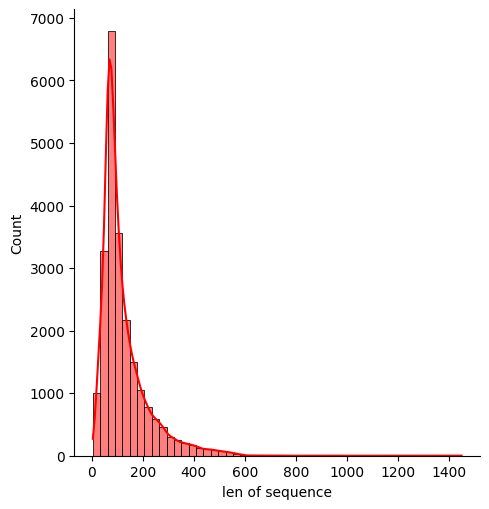

In [22]:
sns.displot(len_words, bins= 50 , kde=True, color="red")
plt.xlabel("len of sequence")
plt.show()

## Build Vocabulary

In [26]:
#### GEt conunt and unique words ####
unique_counts = dict(Counter(alltxt))

words = sorted([key for (key,value) in unique_counts.items() if value > 500])  # select the words having frequncy > 500

# add special tokens
words.append("<UNK>")
words.append("<PAD>")

word2indx= {word:idx for idx, word in enumerate(words)}
indx2word = {idx:word for idx, word in enumerate(words)}

print(f"Unique voacbulary words count : ", len(unique_counts))
print(f"Filtered voacbulary words count : ", len(word2indx))

Unique voacbulary words count :  114390
Filtered voacbulary words count :  904


In [25]:
import json
from datetime import datetime
# Metadata and structure
vocab_data = {
    "version": "1.0",
    "created_at": datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
    "vocabulary": word2indx
}

vocab_filepath= "Vocabulary.json"
with open(vocab_filepath, "w", encoding="utf-8") as f:
    json.dump(vocab_data, f, indent=4)
    f.close()

print(f"Vocabulary saved to {vocab_filepath} file..")

## Load vocabulary

In [30]:
# load vocab_data
vocab_filepath= "Vocabulary.json"

def load_vocabulary(vocab_filepath):
    if os.path.exists(vocab_filepath):
        try:
            with open(vocab_filepath, "r") as f:
                v_ = json.load(f)
                f.close()
                print("Vocabulary loaded successfully! \n")
                
        except json.JSONDecodeError as e:
            print(f"Error decoding JSON: {e}")
            
        except Exception as e:
            raise e
    else:
        print(f"Provided path {vocab_filepath} does not exists")
    return v_ 


vocab_= load_vocabulary(vocab_filepath)
print(vocab_.keys(), "\n")
print(f"Metadata : \n\t {vocab_['version']} \n\t {vocab_['created_at']}")
vocabulary= vocab_['vocabulary']

Vocabulary loaded successfully! 

dict_keys(['version', 'created_at', 'vocabulary']) 

Metadata : 
	 1.0 
	 2025-04-28 17:24:10


# Build IMDB Dataset

We want to follow the same preprocessing steps we did above to make sure its accurate. We will fill words that are not in our tokenizer with Unknown tokens. This will follow our

In [154]:
class MyDataset(Dataset): 
    def __init__(self, path_to_data, word2idx, max_seq_len=200):
        self.word2idx= word2idx
        path_to_pos_fld = os.path.join(path_to_data, "pos")
        path_to_neg_fld = os.path.join(path_to_data, "neg")
        
        path_to_pos_txt = [os.path.join(path_to_pos_fld, file) for file in os.listdir(path_to_pos_fld)]
        path_to_neg_txt = [os.path.join(path_to_neg_fld, file) for file in os.listdir(path_to_neg_fld)]
        
        self.training_files = path_to_pos_txt + path_to_neg_txt
        self.tokenizer = word2idx #tokenize the text (word to int)
        self.max_len = max_seq_len
    
    def __len__(self):
        return len(self.training_files) 

    def __getitem__(self, idx):
        path_to_txt = self.training_files[idx]

        #### prep text #### 
        with open(path_to_txt,"r", encoding="utf-8") as f:
             txt = f.readlines()[0].strip().lower()
             f.close()
        
        txt:str = "".join([x for x in txt if x not in punctuations]) # remove punctuations
        txt:list = word_tokenize(txt)
        txt = [x for x in txt if (x not in stopwords) and (len(x) > 0)] #remove stopwords and blank text
        
        tokenized= [] 
        for word in txt:
             if word in self.tokenizer.keys():
                 tokenized.append(self.tokenizer[word])
             else:
                 tokenized.append(self.tokenizer['<UNK>'])
        
        sample = torch.tensor(tokenized)
        if len(sample) > self.max_len:
            diff = len(sample) - self.max_len
            start_idx = np.random.randint(diff)
            sample = sample[start_idx:start_idx+self.max_len]

        ### GRAB CLASS LABEL ###
        if "neg" in path_to_txt:
            label = 0
        else:
            label = 1
            
        return sample, label        


In [155]:
imdbdataset = MyDataset(dataset_root_dir, vocabulary)
### Check Dataset Works ###
counter = 0
for data, label in imdbdataset:
    print(data.shape)
    print(label)
    break
    

torch.Size([72])
1


In [156]:
### Write Custom Collator ###
def data_collator(batch):
    texts, labels = [], []
    
    for text, label in batch:
        labels.append(label)
        texts.append(text)
        
    labels = torch.tensor(labels)
    
    ### Pad the list of sequences and then convert to tensor like example above but with our padding token <PAD> ###
    texts = nn.utils.rnn.pad_sequence(texts, batch_first=True, padding_value=word2idx["<PAD>"])
    return texts, labels   


In [157]:
#### Data Loader ####
imdbloader = DataLoader(imdbdataset, 
                        batch_size=16, 
                        shuffle=True, 
                        collate_fn=data_collator)


counter = 0
for text, label in imdbloader:
    print(text)
    print(label)
    break

tensor([[902, 902, 902,  ..., 903, 903, 903],
        [881, 902, 508,  ..., 903, 903, 903],
        [572, 191, 902,  ..., 903, 903, 903],
        ...,
        [902, 134, 623,  ..., 903, 903, 903],
        [902, 902, 902,  ..., 903, 903, 903],
        [103, 172,  15,  ..., 903, 903, 903]])
tensor([0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0])


Our Dataset has now been converted to a series of numbers, but we still have a small issue. These numbers don't really mean anything... We just randomly assigned some integer value to each of these words but that doesn't mean they can express the meaning of the word. Therefore we have to use something called an Embedding!

# Embedding

Embeddings are numerical representation of some concept. In our case specifically, we want to represent a specific word with a vector of lenght 256 (arbritrary value that I picked, you can use much larger embedding dimensions). Our goal during the training process is to have words that are similar in meaning to have vectors that are closer together in the high dimensional space. For example, we want words like, Bad, Horrible, and Terrible to be closer together but far apart from words like Good, Amazing, Incredible. To do this we can use something known as a PyTorch Embedding!

The embedding we want will have a row for each unique word in our corpus (along with unknown and padding) and the width will be our embedding dimension. This will be a simple lookup table, where if we want the embedding that goes with the word labeled with the index 3, then we grab the 3rd row of the embedding table. Lets try this!

In [158]:
emb = nn.Embedding(5,3)

print("Embedding Weights")
print(emb.weight)

print("Embedding for Single Sentence")
sentence = torch.tensor([1, 3]) # Sentence words as a list of numbers
print(emb(sentence))
print(emb(sentence).shape)

print("Embedding for Batch Sentence")
batch_sentences = torch.tensor([[1,3], 
                                [1,3], 
                                [1,3]])
print("Batch shape : " , batch_sentences.shape)
print(emb(batch_sentences))
print(emb(batch_sentences).shape) # batch_size, seq_len, emb_dims


Embedding Weights
Parameter containing:
tensor([[ 0.5464, -0.2611,  0.4911],
        [ 1.5574,  1.9191,  1.1514],
        [ 1.4311, -0.1380, -0.2176],
        [ 0.4189,  0.4691, -0.4236],
        [ 0.3551, -0.9436, -0.1065]], requires_grad=True)
Embedding for Single Sentence
tensor([[ 1.5574,  1.9191,  1.1514],
        [ 0.4189,  0.4691, -0.4236]], grad_fn=<EmbeddingBackward0>)
torch.Size([2, 3])
Embedding for Batch Sentence
Batch shape :  torch.Size([3, 2])
tensor([[[ 1.5574,  1.9191,  1.1514],
         [ 0.4189,  0.4691, -0.4236]],

        [[ 1.5574,  1.9191,  1.1514],
         [ 0.4189,  0.4691, -0.4236]],

        [[ 1.5574,  1.9191,  1.1514],
         [ 0.4189,  0.4691, -0.4236]]], grad_fn=<EmbeddingBackward0>)
torch.Size([3, 2, 3])


In [159]:
sentence = torch.tensor([2, 2, 2, 3]) # Sentence words as a list of numbers
print(emb(sentence))
print(emb(sentence).shape)

tensor([[ 1.4311, -0.1380, -0.2176],
        [ 1.4311, -0.1380, -0.2176],
        [ 1.4311, -0.1380, -0.2176],
        [ 0.4189,  0.4691, -0.4236]], grad_fn=<EmbeddingBackward0>)
torch.Size([4, 3])


**Explore the LSTM Module**

```python
nn.LSTM(input_size,  # Expected number of features per input (in our case it will be the embedding depth)
        hidden_size, # Number of features in Hidden State
        num_layers,  # Number of LSTM Cells we want to stack
        batch_first, # Will our tensor have batch dimension or sequence dimension first
)
```

**Inputs to the LSTM**

    H0: Num Layers x batch_size x Hidden Size -> Initialized as 0 if no information given
    C0: Num Layers x batch_size x Hidden Size -> Initialized as 0 if no information give



In [160]:
batch_size = 5        # How Many Samples
sequence_length = 15  # Sequence Length Per Sample
input_size = 10       # Dimension of vector for each timestep in sequence per sample      
hidden_size = 20      # Dimension expansion from Input size Inside the LSTM cell
num_layers = 2        # Number of LSTM Cells

lstm = nn.LSTM(input_size=input_size,
               hidden_size=hidden_size, 
               num_layers=num_layers,
               batch_first=True)



rand = torch.rand(batch_size, sequence_length, input_size) # Batch x sequence length x input_size
h0 = torch.zeros(num_layers, batch_size, hidden_size)      # Num Layers x Batch Size x Hidden State
c0 = torch.zeros(num_layers, batch_size, hidden_size)      # Num Layers x Batch Size x Hidden State

output, (hn, cn) = lstm(rand, (h0, c0))

print("Output:", output.shape) # Returns Batch Size x Sequence Length x Hidden Size -> Hidden state for each timestep
print("Final H:", hn.shape)    # Returns Num Layers x Batch Size x Hidden Size -> Last Hidden state for every layer
print("Final c:", cn.shape)    # Returns Num Layers x Batch Size x Hidden Size -> Last Hidden state for every layer

hn[-1][0] == output[0][-1] # Check if the Last layer, first sample of Hn has same hidden size as first sample, last timestep of output

Output: torch.Size([5, 15, 20])
Final H: torch.Size([2, 5, 20])
Final c: torch.Size([2, 5, 20])


tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True])

In [161]:
output.shape

torch.Size([5, 15, 20])

In [162]:
output[0][-1], output[0][-1].shape

(tensor([ 0.0424,  0.0389,  0.0940,  0.0288, -0.0779,  0.1395, -0.1450,  0.1436,
         -0.0711,  0.0852,  0.0281, -0.0388,  0.0989, -0.0089, -0.1089, -0.0018,
          0.0923,  0.1267,  0.0961,  0.0648], grad_fn=<SelectBackward0>),
 torch.Size([20]))

# Model Design

In [163]:
class MyLSTM(nn.Module):
    def __init__(self, vocab_size, embedding_dims, no_layers, no_hidden, no_classes, device):
        super(MyLSTM, self).__init__()
        # super().__init__()
        self.vocab_size:int = vocab_size 
        self.embedding_dims:int = embedding_dims
        self.no_layers:int = no_layers 
        self.no_hidden:int = no_hidden 
        self.classes:int = no_classes 
        self.device = device 

        #### Define the EMbddding Layer #### 
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dims)

        ## Define the LSTM Layer ## 
        self.lstm= nn.LSTM(input_size= self.embedding_dims, 
                              hidden_size= self.no_hidden, 
                               num_layers= self.no_layers, 
                               batch_first=True,
                               dropout= 0.2)

        ## Final classifier layers ## 
        self.dropout= nn.Dropout(0.2)
        self.dense= nn.Linear(in_features= self.no_hidden, 
                             out_features= self.classes)

    def forward(self, x):
        
        ### INITIALIZE HIDDEN AND CELL STATE AS 0 ###
        # h0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(self.device)  # Num Layers x Batch Size x Hidden State
        # c0 = torch.zeros(self.num_layers, batch_size, self.hidden_size).to(self.device)  # Num Layers x Batch Size x Hidden State
        
        x = self.embedding(x) # batch_size, seq_len, embed_dims 
        
        op, (hn, cn) = self.lstm(x) # pass through LSTM (without zero h0, c0 intitalization)
        last_hidden= op[ : ,-1 ,: ] #Extract the last hidden cell of each batch
        
        out= self.dropout(last_hidden)
        out = self.dense(out)
        return out
    

In [164]:

## SELECT DEVICE ##
device= "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training on Device {device}")

## Load the model ## 
model= MyLSTM(vocab_size= len(vocabulary), 
                embedding_dims=128,
                no_layers=1,
                no_classes=2, 
                no_hidden= 256, 
                device= device)

model= model.to(device)

## Model Training Args ## 
epochs = 15
optimizer = optim.Adam(params=model.parameters(), lr=0.0005)
loss_fn = nn.CrossEntropyLoss()
batch_size = 128

#### Build Training and Testing Dataset ####
train_dataset = MyDataset(os.path.join("..","data","aclImdb","train"), vocabulary)
test_dataset = MyDataset(os.path.join("..","data","aclImdb","test"), vocabulary)

trainloader = DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=data_collator)
valloader = DataLoader(test_dataset, batch_size=128, shuffle=False, collate_fn=data_collator)

def train(model, device, epochs, optimizer, loss_fn, batch_size, trainloader, valloader):
    log_training = {"epoch": [],
                    "training_loss": [],
                    "training_acc": [],
                    "validation_loss": [],
                    "validation_acc": []}
    
    for epoch in range(1, epochs + 1):
        print(f"Starting Epoch {epoch}")
        training_losses, training_accuracies = [], []
        validation_losses, validation_accuracies = [], []
         
        model.train() # Turn On BatchNorm and Dropout

        for sent_, label in tqdm(trainloader):
            sent_, label = sent_.to(device), label.to(device)
            output= model(sent_)
            # print(output.shape, label.shape)

            ## calculate loss 
            loss= loss_fn(output, label)
            training_losses.append(loss.item())

            ## update the parameters 
            optimizer.zero_grad() 
            loss.backward() 
            nn.utils.clip_grad_norm_(model.parameters(), 5) # Just in case ot exploding gradient problem 
            optimizer.step() 

            ## Calculate the training accuracy
            predictions = torch.argmax(output, axis=1) 
            correct_labels = (predictions == label).sum() / len(predictions)  # avg accu. 
            training_accuracies.append(correct_labels.item())

        model.eval() #turning off the gradients
        for sent_, label in tqdm(valloader):
            sent_, label = sent_.to(device), label.to(device)
            with torch.no_grad():
                output= model(sent_) 

                ## calculate loss 
                loss= loss_fn(output, label)
                validation_losses.append(loss.item())
    
                ## Calculate the training accuracy
                predictions = torch.argmax(output, axis=1) 
                correct_labels = (predictions == label).sum() / len(predictions)  # avg accu. 
                validation_accuracies.append(correct_labels.item())
                
        ## per epoch
        training_loss_mean, training_acc_mean = np.mean(training_losses), np.mean(training_accuracies)
        valid_loss_mean, valid_acc_mean = np.mean(validation_losses), np.mean(validation_accuracies)
    
        log_training["epoch"].append(epoch)
        log_training["training_loss"].append(training_loss_mean)
        log_training["training_acc"].append(training_acc_mean)
        log_training["validation_loss"].append(valid_loss_mean)
        log_training["validation_acc"].append(valid_acc_mean)

        print("Training Loss:", training_loss_mean) 
        print("Training Acc:", training_acc_mean)
        print("Validation Loss:", valid_loss_mean)
        print("Validation Acc:", valid_acc_mean)
        
        return log_training, model    

Training on Device cpu


In [165]:
%%time
training_logging, model = train(model=model,
                                device=device,
                                epochs=epochs,
                                optimizer=optimizer,
                                loss_fn=loss_fn,
                                batch_size=batch_size,
                                trainloader=trainloader,
                                valloader=valloader)

Starting Epoch 1


100%|████████████████████████████████████████| 196/196 [04:23<00:00,  1.35s/it]

Training Loss: 0.6897203797674448
Training Acc: 0.5432314448437449
Validation Loss: 0.7060917144527241
Validation Acc: 0.5073740433673469
CPU times: total: 48min 46s
Wall time: 21min 3s


In [111]:
!pip install tqdm -q

In [ ]:
from 